# Full analysis with nested CV

In [18]:
import pickle
import numpy as np
import pandas as pd

In [19]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import math

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
import nibabel as nib

In [22]:
from nilearn import plotting


In [23]:
data_path = '/gpfs/projects/sanlab/bsmith16/data/'

## Setup

In [24]:
metadata = pickle.load(open(data_path + "first_subs_nifti_metadata.pkl",'rb'))

In [25]:
from measure_results import *

In [26]:
def within_group_performance(results,cor_func,
                             group_col_name='result_group',
                             obs_col_name='y',
                             pred_col_name='y_pred'
                             
                            ):
    results[obs_col_name] = results[obs_col_name].astype(float)
    results[pred_col_name] = results[pred_col_name].astype(float)
    within_subj_predictions = []
    #print(results[group_col_name].unique())
    for group in results[group_col_name].unique():
        group_results = results.loc[results[group_col_name]==group,].copy()

        #get means and SDs
        obs_mean = np.mean(group_results[obs_col_name])
        pred_mean = np.mean(group_results[pred_col_name])
        obs_sd = np.std(group_results[obs_col_name])
        pred_sd = np.std(group_results[pred_col_name])

        #mean center
        group_results[obs_col_name] = (group_results[obs_col_name] - obs_mean)
        group_results[pred_col_name] = (group_results[pred_col_name] - pred_mean)
        
        if(group_results.shape[0]==0):
            print(group_results.shape)
            print(group)

        within_subj_prediction = pearsonr(group_results[obs_col_name],group_results[pred_col_name])[0]
        #print(within_subj_prediction)
        #print(math.pow(pearsonr(group_results[obs_col_name],group_results['y_pred'])[0],2))


        #what if we we re-ranked the predicted values into groups along the 
        if (within_subj_prediction< (-0.5)):

            sp = sns.scatterplot(group_results[obs_col_name],group_results[pred_col_name])
            plt.show()
            display(pd.DataFrame(group_results.groupby(obs_col_name).y_pred.mean()))
            #display(group_results)
        within_subj_predictions = within_subj_predictions + [within_subj_prediction]
    return(within_subj_predictions)

## ns_w_hrf_from_spm_40subs

In [27]:
loocv_results = pickle.load(open(data_path + "train_test_results_ns_w_hrf_from_spm_40subs.pkl",'rb'))
test_scores_same=loocv_results[0]
tt_results=loocv_results[1]
results_by_trainset_item=loocv_results[2]

In [28]:
results_by_trainset_item

,y,group,y_pred
0,7.0,DEV001,7.46465
1,6.0,DEV001,5.41228
2,6.0,DEV001,5.92956
3,5.0,DEV001,5.26228
4,7.0,DEV001,7.23188
...,...,...,...
2457,5.0,DEV056,6.64668
2458,7.0,DEV056,7.06105
2459,6.0,DEV056,5.78202
2460,8.0,DEV056,7.3732


In [29]:
results = pd.concat([metadata,results_by_trainset_item],axis=1)
results['result_group'] = results.group + "_" + results.run
#trim subjects where we don't have data. this will be 20 because there's 20 subjects in the metadata but only 40 being processed.
results = results.loc[pd.isnull(results.result_group)==False,]

In [30]:

within_group_predictions = within_group_performance(
    results,pearsonr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj = math.pow(np.mean(within_group_predictions),2)
print("Pearson's R^2 within subject and run:")
print(r2_score_within_subj)

within_subj_predictions = within_group_performance(results,pearsonr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj_run = math.pow(np.mean(within_subj_predictions),2)
print("Pearson's R^2 within subject only:")
print(r2_score_within_subj_run)



print("Pearson's R^2 across subjects:")
print(math.pow(pearsonr(results['y'],results['y_pred'])[0],2))

Pearson's R^2 within subject and run:
0.2547561984707979
Pearson's R^2 within subject only:
0.2474323602984913
Pearson's R^2 across subjects:
0.22326323278626192


In [31]:
within_group_predictions_sp = within_group_performance(
    results,spearmanr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj = np.mean(within_group_predictions_sp)
print("Spearman's rho within subject and run:")
print(rho_score_within_subj)

within_subj_predictions_sp = within_group_performance(results,spearmanr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj_run = np.mean(within_subj_predictions_sp)
print("Spearman's rho within subject only:")
print(rho_score_within_subj_run)



print("Spearman's rho across subjects:")
print(spearmanr(results['y'],results['y_pred'])[0])

Spearman's rho within subject and run:
0.504733789705819
Spearman's rho within subject only:
0.497425733450222
Spearman's rho across subjects:
0.4801862447703641


## ns_6s_no_hrf_from_spm_40subs

In [32]:
loocv_results = pickle.load(open(data_path + "train_test_results_ns_6s_no_hrf_from_spm_40subs.pkl",'rb'))
test_scores_same=loocv_results[0]
tt_results=loocv_results[1]
results_by_trainset_item=loocv_results[2]

In [33]:
results = pd.concat([metadata,results_by_trainset_item],axis=1)
results['result_group'] = results.group + "_" + results.run
#trim subjects where we don't have data. this will be 20 because there's 20 subjects in the metadata but only 40 being processed.
results = results.loc[pd.isnull(results.result_group)==False,]

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


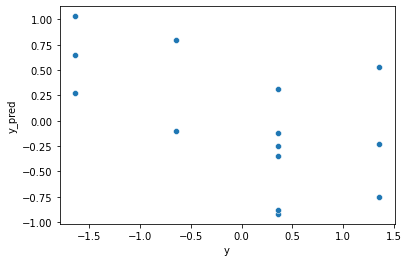

,y_pred
y,
-1.642857,0.653976
-0.642857,0.343554
0.357143,-0.366721
1.357143,-0.149569


Pearson's R^2 within subject and run:
0.014796586224707434
Pearson's R^2 within subject only:
0.01313927986042674
Pearson's R^2 across subjects:
0.010398565820511711


In [34]:

within_group_predictions = within_group_performance(
    results,pearsonr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj = math.pow(np.mean(within_group_predictions),2)
print("Pearson's R^2 within subject and run:")
print(r2_score_within_subj)

within_subj_predictions = within_group_performance(results,pearsonr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj_run = math.pow(np.mean(within_subj_predictions),2)
print("Pearson's R^2 within subject only:")
print(r2_score_within_subj_run)



print("Pearson's R^2 across subjects:")
print(math.pow(pearsonr(results['y'],results['y_pred'])[0],2))

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


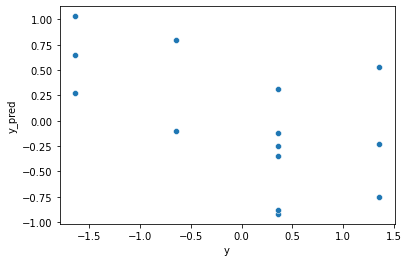

,y_pred
y,
-1.642857,0.653976
-0.642857,0.343554
0.357143,-0.366721
1.357143,-0.149569


Spearman's rho within subject and run:
0.12164121926677418
Spearman's rho within subject only:
0.1146266978518824
Spearman's rho across subjects:
0.10179533937104121


In [35]:
within_group_predictions_sp = within_group_performance(
    results,spearmanr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj = np.mean(within_group_predictions_sp)
print("Spearman's rho within subject and run:")
print(rho_score_within_subj)

within_subj_predictions_sp = within_group_performance(results,spearmanr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj_run = np.mean(within_subj_predictions_sp)
print("Spearman's rho within subject only:")
print(rho_score_within_subj_run)



print("Spearman's rho across subjects:")
print(spearmanr(results['y'],results['y_pred'])[0])

## ns_no_hrf_from_spm_40subs

In [41]:
loocv_results = pickle.load(open(data_path + "train_test_results_ns_no_hrf_from_spm_40subs.pkl",'rb'))
test_scores_same=loocv_results[0]
tt_results=loocv_results[1]
results_by_trainset_item=loocv_results[2]

In [42]:
results = pd.concat([metadata,results_by_trainset_item],axis=1)
results['result_group'] = results.group + "_" + results.run
#trim subjects where we don't have data. this will be 20 because there's 20 subjects in the metadata but only 40 being processed.
results = results.loc[pd.isnull(results.result_group)==False,]

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


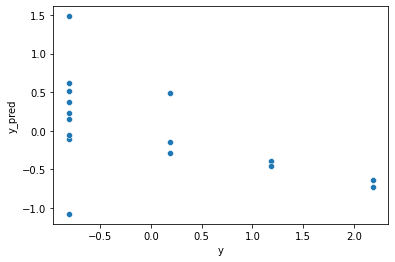

,y_pred
y,
-0.8125,0.238212
0.1875,0.020276
1.1875,-0.423308
2.1875,-0.679061


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


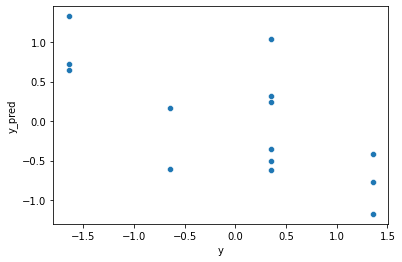

,y_pred
y,
-1.642857,0.899667
-0.642857,-0.224108
0.357143,0.018454
1.357143,-0.787171


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


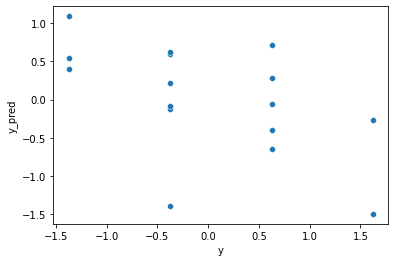

,y_pred
y,
-1.375,0.677456
-0.375,-0.026542
0.625,-0.021202
1.625,-0.883556


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


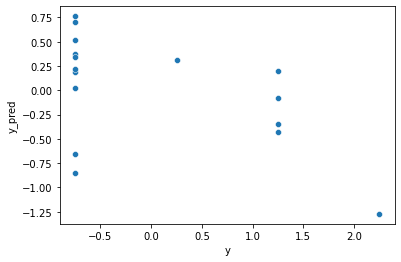

,y_pred
y,
-0.75,0.162018
0.25,0.308981
1.25,-0.164169
2.25,-1.272482


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


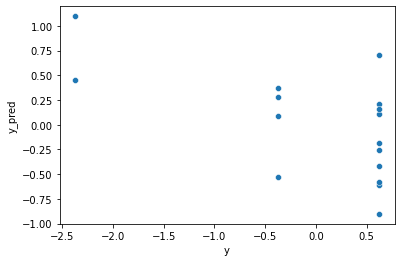

,y_pred
y,
-2.375,0.777107
-0.375,0.051955
0.625,-0.176203


Pearson's R^2 within subject and run:
0.0015236721319045932
Pearson's R^2 within subject only:
0.0011288811686392237
Pearson's R^2 across subjects:
0.0006871510163054083


In [43]:

within_group_predictions = within_group_performance(
    results,pearsonr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj = math.pow(np.mean(within_group_predictions),2)
print("Pearson's R^2 within subject and run:")
print(r2_score_within_subj)

within_subj_predictions = within_group_performance(results,pearsonr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj_run = math.pow(np.mean(within_subj_predictions),2)
print("Pearson's R^2 within subject only:")
print(r2_score_within_subj_run)



print("Pearson's R^2 across subjects:")
print(math.pow(pearsonr(results['y'],results['y_pred'])[0],2))

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


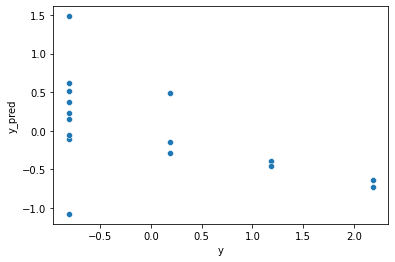

,y_pred
y,
-0.8125,0.238212
0.1875,0.020276
1.1875,-0.423308
2.1875,-0.679061


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


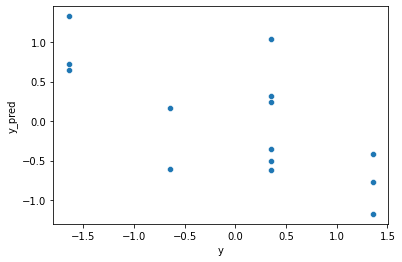

,y_pred
y,
-1.642857,0.899667
-0.642857,-0.224108
0.357143,0.018454
1.357143,-0.787171


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


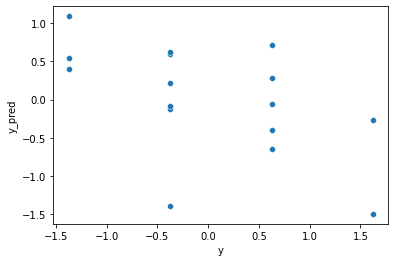

,y_pred
y,
-1.375,0.677456
-0.375,-0.026542
0.625,-0.021202
1.625,-0.883556


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


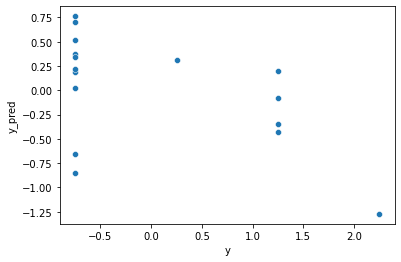

,y_pred
y,
-0.75,0.162018
0.25,0.308981
1.25,-0.164169
2.25,-1.272482


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


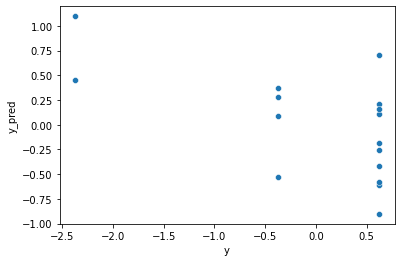

,y_pred
y,
-2.375,0.777107
-0.375,0.051955
0.625,-0.176203


Spearman's rho within subject and run:
0.039034243068165074
Spearman's rho within subject only:
0.03359882689379532
Spearman's rho across subjects:
0.034733471357189336


In [44]:
within_group_predictions_sp = within_group_performance(
    results,spearmanr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj = np.mean(within_group_predictions_sp)
print("Spearman's rho within subject and run:")
print(rho_score_within_subj)

within_subj_predictions_sp = within_group_performance(results,spearmanr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj_run = np.mean(within_subj_predictions_sp)
print("Spearman's rho within subject only:")
print(rho_score_within_subj_run)



print("Spearman's rho across subjects:")
print(spearmanr(results['y'],results['y_pred'])[0])

These numbers are really bad, but we might expect those low scores for no HRF with 2s only.

## ns_w_hrf_from_spm_at_fingerpress_40subs

In [45]:
loocv_results = pickle.load(open(data_path + "train_test_results_ns_w_hrf_from_spm_at_fingerpress_40subs.pkl",'rb'))
test_scores_same=loocv_results[0]
tt_results=loocv_results[1]
results_by_trainset_item=loocv_results[2]

In [46]:
results = pd.concat([metadata,results_by_trainset_item],axis=1)
results['result_group'] = results.group + "_" + results.run
#trim subjects where we don't have data. this will be 20 because there's 20 subjects in the metadata but only 40 being processed.
results = results.loc[pd.isnull(results.result_group)==False,]

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


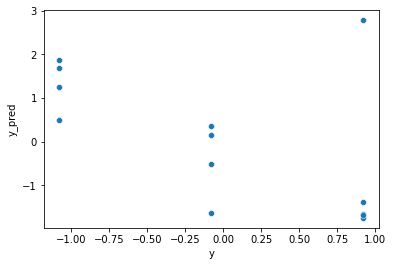

,y_pred
y,
-1.076923,1.332698
-0.076923,-0.406930
0.923077,-0.740614


Pearson's R^2 within subject and run:
0.06968384338062028
Pearson's R^2 within subject only:
0.054564235148747614
Pearson's R^2 across subjects:
0.04721550206692823


In [47]:
within_group_predictions = within_group_performance(
    results,pearsonr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj = math.pow(np.mean(within_group_predictions),2)
print("Pearson's R^2 within subject and run:")
print(r2_score_within_subj)

within_subj_predictions = within_group_performance(results,pearsonr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj_run = math.pow(np.mean(within_subj_predictions),2)
print("Pearson's R^2 within subject only:")
print(r2_score_within_subj_run)



print("Pearson's R^2 across subjects:")
print(math.pow(pearsonr(results['y'],results['y_pred'])[0],2))

That's implausibly bad for finger-press. Need to re-investigate.

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


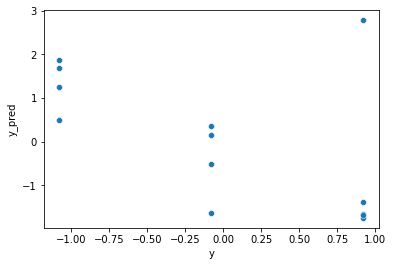

,y_pred
y,
-1.076923,1.332698
-0.076923,-0.406930
0.923077,-0.740614


Spearman's rho within subject and run:
0.2639769750955948
Spearman's rho within subject only:
0.23358988665767963
Spearman's rho across subjects:
0.22100484993490596


In [48]:
within_group_predictions_sp = within_group_performance(
    results,spearmanr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj = np.mean(within_group_predictions_sp)
print("Spearman's rho within subject and run:")
print(rho_score_within_subj)

within_subj_predictions_sp = within_group_performance(results,spearmanr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj_run = np.mean(within_subj_predictions_sp)
print("Spearman's rho within subject only:")
print(rho_score_within_subj_run)



print("Spearman's rho across subjects:")
print(spearmanr(results['y'],results['y_pred'])[0])

## ns_2s_split_*_40subs

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


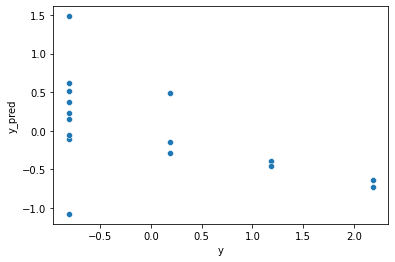

,y_pred
y,
-0.8125,0.238212
0.1875,0.020276
1.1875,-0.423308
2.1875,-0.679061


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


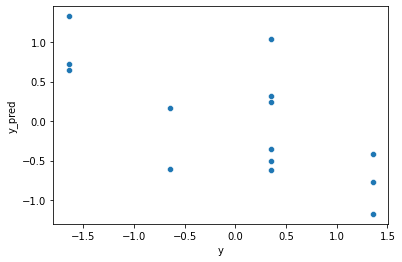

,y_pred
y,
-1.642857,0.899667
-0.642857,-0.224108
0.357143,0.018454
1.357143,-0.787171


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


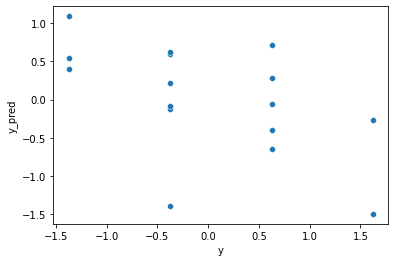

,y_pred
y,
-1.375,0.677456
-0.375,-0.026542
0.625,-0.021202
1.625,-0.883556


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


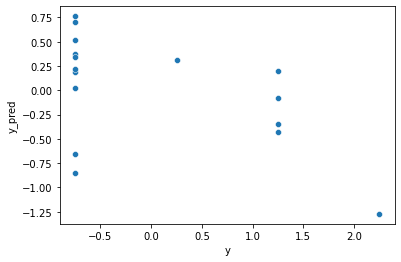

,y_pred
y,
-0.75,0.162018
0.25,0.308981
1.25,-0.164169
2.25,-1.272482


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


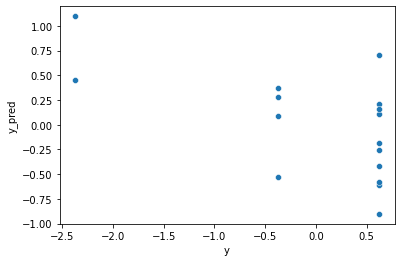

,y_pred
y,
-2.375,0.777107
-0.375,0.051955
0.625,-0.176203


Pearson's R^2 within subject and run:
0.0015236721319045932
Pearson's R^2 within subject only:
0.0011288811686392237
Pearson's R^2 across subjects:
0.0006871510163054083


In [12]:
loocv_results = pickle.load(open(data_path + "train_test_results_ns_2s_split_0_40subs.pkl",'rb'))
test_scores_same=loocv_results[0]
tt_results=loocv_results[1]
results_by_trainset_item=loocv_results[2]

results = pd.concat([metadata,results_by_trainset_item],axis=1)
results['result_group'] = results.group + "_" + results.run
#trim subjects where we don't have data. this will be 20 because there's 20 subjects in the metadata but only 40 being processed.
results = results.loc[pd.isnull(results.result_group)==False,]


within_group_predictions = within_group_performance(
    results,pearsonr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj = math.pow(np.mean(within_group_predictions),2)
print("Pearson's R^2 within subject and run:")
print(r2_score_within_subj)

within_subj_predictions = within_group_performance(results,pearsonr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj_run = math.pow(np.mean(within_subj_predictions),2)
print("Pearson's R^2 within subject only:")
print(r2_score_within_subj_run)



print("Pearson's R^2 across subjects:")
print(math.pow(pearsonr(results['y'],results['y_pred'])[0],2))

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


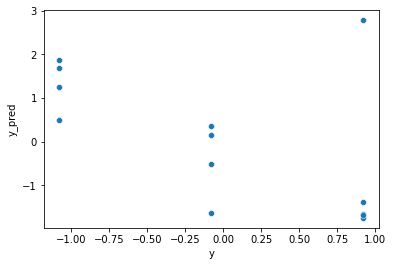

,y_pred
y,
-1.076923,1.332698
-0.076923,-0.406930
0.923077,-0.740614


Spearman's rho within subject and run:
0.2639769750955948
Spearman's rho within subject only:
0.23358988665767963
Spearman's rho across subjects:
0.22100484993490596


In [49]:
within_group_predictions_sp = within_group_performance(
    results,spearmanr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj = np.mean(within_group_predictions_sp)
print("Spearman's rho within subject and run:")
print(rho_score_within_subj)

within_subj_predictions_sp = within_group_performance(results,spearmanr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj_run = np.mean(within_subj_predictions_sp)
print("Spearman's rho within subject only:")
print(rho_score_within_subj_run)



print("Spearman's rho across subjects:")
print(spearmanr(results['y'],results['y_pred'])[0])

### 2s

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


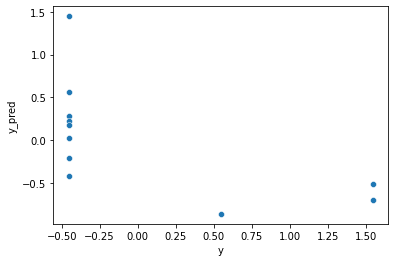

,y_pred
y,
-0.454545,0.260062
0.545455,-0.866231
1.545455,-0.607135


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


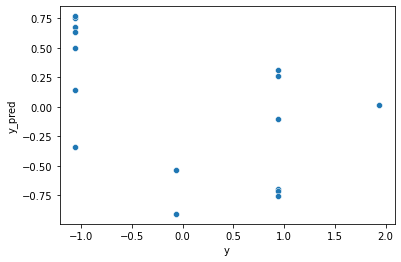

,y_pred
y,
-1.0625,0.446328
-0.0625,-0.721532
0.9375,-0.283022
1.9375,0.016899


Pearson's R^2 within subject and run:
0.0032775026968980187
Pearson's R^2 within subject only:
0.004250309334337535
Pearson's R^2 across subjects:
0.0036006249725942844


In [50]:
loocv_results = pickle.load(open(data_path + "train_test_results_ns_2s_split_2_40subs.pkl",'rb'))
test_scores_same=loocv_results[0]
tt_results=loocv_results[1]
results_by_trainset_item=loocv_results[2]

results = pd.concat([metadata,results_by_trainset_item],axis=1)
results['result_group'] = results.group + "_" + results.run
#trim subjects where we don't have data. this will be 20 because there's 20 subjects in the metadata but only 40 being processed.
results = results.loc[pd.isnull(results.result_group)==False,]


within_group_predictions = within_group_performance(
    results,pearsonr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj = math.pow(np.mean(within_group_predictions),2)
print("Pearson's R^2 within subject and run:")
print(r2_score_within_subj)

within_subj_predictions = within_group_performance(results,pearsonr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj_run = math.pow(np.mean(within_subj_predictions),2)
print("Pearson's R^2 within subject only:")
print(r2_score_within_subj_run)



print("Pearson's R^2 across subjects:")
print(math.pow(pearsonr(results['y'],results['y_pred'])[0],2))

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


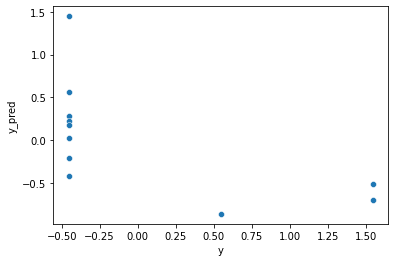

,y_pred
y,
-0.454545,0.260062
0.545455,-0.866231
1.545455,-0.607135


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


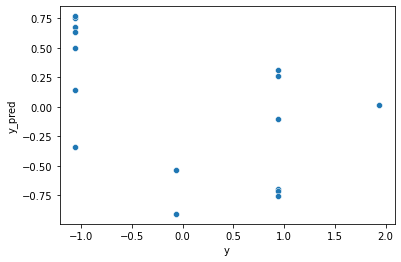

,y_pred
y,
-1.0625,0.446328
-0.0625,-0.721532
0.9375,-0.283022
1.9375,0.016899


Spearman's rho within subject and run:
0.05724947769978359
Spearman's rho within subject only:
0.06519439649492535
Spearman's rho across subjects:
0.06334057103506147


In [51]:
within_group_predictions_sp = within_group_performance(
    results,spearmanr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj = np.mean(within_group_predictions_sp)
print("Spearman's rho within subject and run:")
print(rho_score_within_subj)

within_subj_predictions_sp = within_group_performance(results,spearmanr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj_run = np.mean(within_subj_predictions_sp)
print("Spearman's rho within subject only:")
print(rho_score_within_subj_run)



print("Spearman's rho across subjects:")
print(spearmanr(results['y'],results['y_pred'])[0])

### 4s

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


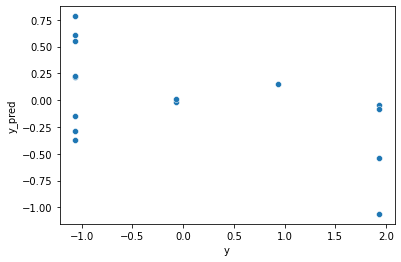

,y_pred
y,
-1.066667,0.196826
-0.066667,-0.000570
0.933333,0.155172
1.933333,-0.432159


Pearson's R^2 within subject and run:
0.047083100956367925
Pearson's R^2 within subject only:
0.04917184087123544
Pearson's R^2 across subjects:
0.04518776118862989


In [52]:
loocv_results = pickle.load(open(data_path + "train_test_results_ns_2s_split_4_40subs.pkl",'rb'))
test_scores_same=loocv_results[0]
tt_results=loocv_results[1]
results_by_trainset_item=loocv_results[2]

results = pd.concat([metadata,results_by_trainset_item],axis=1)
results['result_group'] = results.group + "_" + results.run
#trim subjects where we don't have data. this will be 20 because there's 20 subjects in the metadata but only 40 being processed.
results = results.loc[pd.isnull(results.result_group)==False,]


within_group_predictions = within_group_performance(
    results,pearsonr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj = math.pow(np.mean(within_group_predictions),2)
print("Pearson's R^2 within subject and run:")
print(r2_score_within_subj)

within_subj_predictions = within_group_performance(results,pearsonr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
r2_score_within_subj_run = math.pow(np.mean(within_subj_predictions),2)
print("Pearson's R^2 within subject only:")
print(r2_score_within_subj_run)



print("Pearson's R^2 across subjects:")
print(math.pow(pearsonr(results['y'],results['y_pred'])[0],2))

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


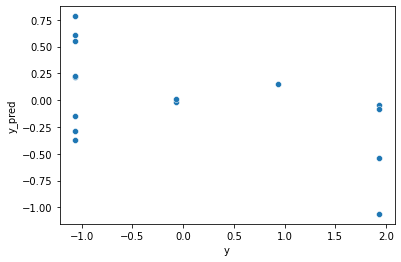

,y_pred
y,
-1.066667,0.196826
-0.066667,-0.000570
0.933333,0.155172
1.933333,-0.432159


Spearman's rho within subject and run:
0.2169864073078494
Spearman's rho within subject only:
0.2217472454648207
Spearman's rho across subjects:
0.20238953083730976


In [53]:
within_group_predictions_sp = within_group_performance(
    results,spearmanr_cor_func,'result_group',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj = np.mean(within_group_predictions_sp)
print("Spearman's rho within subject and run:")
print(rho_score_within_subj)

within_subj_predictions_sp = within_group_performance(results,spearmanr_cor_func,'subject',obs_col_name='y',pred_col_name='y_pred') 
rho_score_within_subj_run = np.mean(within_subj_predictions_sp)
print("Spearman's rho within subject only:")
print(rho_score_within_subj_run)



print("Spearman's rho across subjects:")
print(spearmanr(results['y'],results['y_pred'])[0])